## Marie 2020

Algorithm with small iterations

In [1]:
# General
import glob
import re
import os.path
import warnings
# warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
import copy

# Arrays & Displays
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd

# Data treatment
from datetime import datetime
from scipy.optimize import curve_fit

# Custom
# import functions as f
# import dataUtils as du

# Statistics
from sklearn import linear_model, neighbors
from pykalman import KalmanFilter

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [2]:
PRMS = {
    'n':              5, # R+ is defined as omega(R+) = n * f
    'sav_fgs':        False,
}

PTHS = {
    'ds_glob_path':    '/home/arthur/data/cyclobs/SAR_compilations_in_nc/SAR_centered_rotated_files_13052022_with_extra_params.nc',
    'sar_dir':         '/home/arthur/data/cyclobs/centered_rotated_files_31012022/',
    'sct_dir':         '/home/arthur/data/scatterometer/KNMI/product_JF_rotated_filtered_v3/POLAR/2020/EP182020/',
}

### 1) SAR data

In [3]:
### OPEN DATA
dsg = xr.open_dataset(PTHS['ds_glob_path'])
dsg.where(dsg.storm_name == 'MARIE', drop=True).B_hol

/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/backends/plugins.py:71: RuntimeWarning: Engine 'cfgrib' loading failed:
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/lib-dynload/../../libffi.so.8: version `LIBFFI_CLOSURE_7.0' not found (required by /home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/_cffi_backend.cpython-38-x86_64-linux-gnu.so)
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


<xarray.DataArray 'B_hol' (time: 5)>
array([1.79940384, 2.37396689, 1.67238905, 1.78461914, 1.59906357])
Coordinates:
  * time     (time) datetime64[ns] 2020-10-02T02:23:31 ... 2020-10-04T14:29:05

In [4]:
### MARIE
p1    = 'rs2--owi-ca-20201001t133839-20201001t133955-00003-3268A_sw_ep182020_cyclone.nc'
p2    = 'rs2--owi-ca-20201002t022254-20201002t022409-00003-3268A_sw_ep182020_cyclone.nc'
p3    = 's1a-ew-owi-ca-20201003t022600-20201003t022817-000003-04082E_sw_ep182020_cyclone.nc'
p4    = 'rs2--owi-ca-20201003t141913-20201003t142136-00003-3268A_sw_ep182020_cyclone.nc'
p5    = 's1b-ew-owi-ca-20201004t142803-20201004t143007-000003-02CF68_sw_ep182020_cyclone.nc'

p1dsg = 'rs2--owi-cm-20201001t133839-20201001t133955-00003-3268A_sw.nc'
p2dsg = 'rs2--owi-cm-20201002t022254-20201002t022409-00003-3268A_sw.nc'
p3dsg = 's1a-ew-owi-cm-20201003t022600-20201003t022817-000003-04082E_sw.nc'
p4dsg = 'rs2--owi-cm-20201003t141913-20201003t142136-00003-3268A_sw.nc'
p5dsg = 's1b-ew-owi-cm-20201004t142803-20201004t143007-000003-02CF68_sw.nc'

Text(0.5, 1.0, 'MARIE, EP182020')

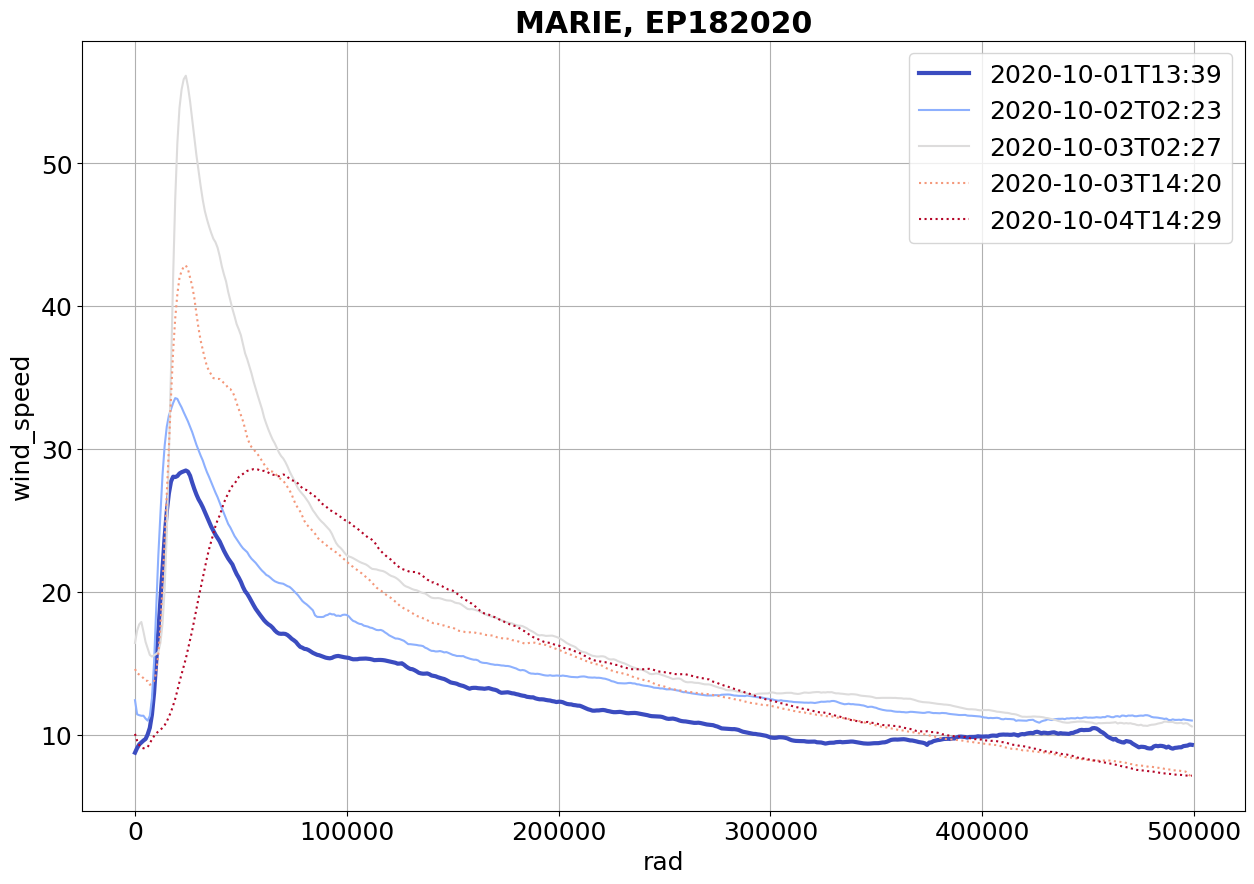

In [5]:
colors = mpl.cm.coolwarm(np.linspace(0, 1, 5))

ds1 = xr.open_dataset(PTHS['sar_dir'] + p1).isel(time=0)
ds2 = xr.open_dataset(PTHS['sar_dir'] + p2).isel(time=0)
ds3 = xr.open_dataset(PTHS['sar_dir'] + p3).isel(time=0)
ds4 = xr.open_dataset(PTHS['sar_dir'] + p4).isel(time=0)
ds5 = xr.open_dataset(PTHS['sar_dir'] + p5).isel(time=0)

ws1 = ds1.wind_speed.mean(dim='theta', skipna=True)
ws2 = ds2.wind_speed.mean(dim='theta', skipna=True)
ws3 = ds3.wind_speed.mean(dim='theta', skipna=True)
ws4 = ds4.wind_speed.mean(dim='theta', skipna=True)
ws5 = ds5.wind_speed.mean(dim='theta', skipna=True)

ws1.plot(label='{}'.format(np.datetime_as_string(ds1.time, unit='m')), c=colors[0], linewidth=3)
ws2.plot(label='{}'.format(np.datetime_as_string(ds2.time, unit='m')), c=colors[1])
ws3.plot(label='{}'.format(np.datetime_as_string(ds3.time, unit='m')), c=colors[2])
ws4.plot(label='{}'.format(np.datetime_as_string(ds4.time, unit='m')), c=colors[3], linestyle='dotted')
ws5.plot(label='{}'.format(np.datetime_as_string(ds5.time, unit='m')), c=colors[4], linestyle='dotted')
plt.grid();plt.legend();plt.title('MARIE, EP182020', weight='bold')

# 36hrs between both images

### 2) Functions and model

In [67]:
### FUNCTIONS

def coriolis(lat):
    '''Latitude must be in degrees.'''
    Omega = 7.2921e-5                            # Earth rotation vector
    fcor  = 2 * Omega * np.sin(lat * np.pi / 180) # Coriolis parameter at 20° latitude and assuming it's constant 
    return fcor

def holland_profile(r, lat, pn, pc, Vmin, Rmax, Vmax):
    '''We assume that rho is constant and equals 1.15 kg.m-3'''
    fcor  = abs(coriolis(lat))
    rho   = 1.15
    # B     = (Vmax ** 2) * rho * np.e / (pn - pc)
    B     = ((Vmax - Vmin) ** 2) * rho * np.e / (pn - pc)
    A     = Rmax ** B
    
    r     = r.astype(float) + 0.001 # To avoid dividing by zero
    V     = r * 0.
    V     = Vmin + np.sqrt(A * B * (pn - pc) * np.exp((-1) * A / (r ** B)) / (rho * r ** B) + (r ** 2 * fcor ** 2) / 4) - (r * fcor / 2)
    return V

rs = np.linspace(10, 500000, 50001) # define dr accordingly

def vorticity(r, v):
    '''Relative vorticity'''
    dr = 10 # meters
    return (1 / r) * np.gradient(r * v, dr)

def get_v(ds, fcor, L):
    ws = ds.wind_speed.mean(dim='theta', skipna=True)
    r = ws.rad / L
    v = ws     / (fcor * L)

    V = xr.DataArray(
        data=v,
        coords={'rad': r}
    )
    return V

def v_k10(v0, t, lbda=None):
    # Initial
    v          = np.zeros_like(v0.rad)                  # Raw v0
    v_prop_in  = v0.interp({'rad': v0.rad * np.exp(t)}) # Inner-core: v0 interpolated on r * e^t
    nr_term    = np.sqrt(1 + 2 * (np.log(v0.rad) + t))  # Near-core (1)
    v_prop_nr  = v0.interp({'rad': nr_term})            # Near-core (2)
    ou_term    = np.sqrt(v0.rad ** 2 + 2 * t)           # Outer-core (1)
    v_prop_ou  = v0.interp({'rad': ou_term})            # Outer-core (2)
    
    # No friction
    if lbda is None:
        vin        = v_prop_in * np.exp(t) + v0.rad * (np.exp(2 * t) - 1) / 2                                      # Inner-core
        vnr        = nr_term * v_prop_nr / v0.rad + (1 - v0.rad ** 2) / (2 * v0.rad) + np.log(v0.rad) / v0.rad + t / v0.rad # Near-core
        vou        = ou_term * v_prop_ou / v0.rad + t / v0.rad                                                     # Outer-core
        
    # Friction
    else:
        vin        = v_prop_in * np.exp((1 - lbda) * t) + v0.rad * (1 - np.exp((2 - lbda) * t)) / (lbda - 2)      # Inner-core
        vnr        = nr_term * v_prop_nr * np.exp(-lbda * t) / v0.rad + (lbda * v0.rad ** 2 - 2 * v0.rad ** lbda) / (lbda * v0.rad * (lbda - 2)) - np.exp(-lbda * t) / (lbda * v0.rad)
        vou        = ou_term * v_prop_ou * np.exp(-lbda * t) / v0.rad + (1 - np.exp(-lbda * t)) / (lbda * v0.rad) # Outer-core

    # Declare final output
    bd              = np.exp(-t)
    v[v0.rad < bd]  = vin[v0.rad < bd]
    v[v0.rad >= bd] = vnr[v0.rad >= bd]
    v[v0.rad >= 1]  = vou[v0.rad >= 1]
    
    return v

def compute_RV_plus(r, V, fcor, n=5):
    # Compute R+
    rm       = r[np.nanargmax(V)]
    out      = r > rm          # To find outer-core
    r        = r[out]
    V        = V[out]
    vrt      = vorticity(r, V) # Relative vorticity
    vrt_plan = fcor            # Planetary vorticity

    try: 
        R_plus = r[abs(vrt - n * vrt_plan) < 1e-6][0] # R+
        V_plus = V[r >= R_plus][0]
    except IndexError:
        print('Error: R+ non defined.')
        R_plus = V_plus = np.nan
    
    return R_plus, V_plus

##############################
### SMOOTHING WITH HOLLAND ###
##############################

def get_valid_radii(r, V):
    '''Given the wind profile V, returns the largest radius (and asociated V) on which the profile can be fitted. 
    Indeed, sometimes V isn't defined from r = 0 to r = 500, in this case the largest domain is taken instead.'''
    # Initialize first and last indexes
    first_valid_index = 0
    last_valid_index  = len(r)
    
    ### Lower bound
    # We change it if V[0] = nan
    if np.isnan(V[0]):
        first_valid_index = np.min(np.where(np.isfinite(V)))
        
    ### Upper bound
    # We change it if there is a nan somewhere
    if np.count_nonzero(np.isnan(V[first_valid_index:])) > 0:
        last_valid_index  = np.min(np.where(np.isnan(V[first_valid_index:]))[0])# returns the index of the last valid value before the first nan
        last_valid_index += first_valid_index - 1
        
        
    # Define r and spdm
    r = r[first_valid_index:last_valid_index]
    V = V[first_valid_index:last_valid_index]
    
    return r, V

def holland_profile2(r, fcor, B, Vmin, Rmax, Vmax):
    '''We assume that rho is constant and equals 1.15 kg.m-3'''
    rho    = 1.15

    r      = r.astype(float) + 0.001 # To avoid dividing by zero
    r_star = (Rmax / r) ** B
    V      = r * 0.
    V      = Vmin + np.sqrt( ((Vmax - Vmin) ** 2) * r_star * np.exp(1 - r_star) + (r * fcor / 2) ** 2) - (r * fcor / 2)
    return V

def fit_holland2(r, spdm, fcor, B, Vmin, Rmax, Vmax):
    '''Fit the Holland profile given initial values of lat, pn, pc, Vmin, Rmax and Vmax.
    Returns the optimal parameters found with curve_fit()'''
    # Define the bounds
    BOUNDS = {
        'B':    [1, 3],
        'Vmin': [0, 50],
        'Rmax': [5 * 1000, 500 * 1000],
        'Vmax': [10, 100]
        } 
    # Don't take std into account
    sigma = None
    # Fit
    popt, pcov = curve_fit(
        lambda r, B, Vmin, Rmax, Vmax: holland_profile2(r, fcor, B, Vmin, Rmax, Vmax), 
        r, 
        spdm, 
        p0=[B, Vmin, Rmax, Vmax], 
        bounds=(tuple([BOUNDS[e][0] for e in BOUNDS.keys()]), # NB: lat is fixed
                tuple([BOUNDS[e][1] for e in BOUNDS.keys()])
               ) 
    ) 
    return popt, pcov

def smooth_with_holland(r, V, fcor):
    # Initialize Holland
    B_guess = 1.8
    vmx     = np.nanmax(V)
    rmx     = r[np.nanargmax(V)]
    vmn     = np.nanmin(V)
    
    # Get valid domain
    r_crop, V_crop = get_valid_radii(r, V)
    
    # Fit Holland
    popt, _ = fit_holland2(r_crop, V_crop, fcor, B_guess, vmn, rmx, vmx)
    V_fit   = holland_profile2(r, fcor, popt[0], popt[1], popt[2], popt[3])
    
    return V_fit

################
### FRICTION ###
################

def N(r, M):
    '''Rotational stability frequency'''
    dr = 10 # meters
    N2 = np.gradient(M ** 2, dr) / (r ** 3)
    return np.sqrt(N2)

def compute_lbda(r, V, fcor, R_plus, V_plus, Cd_plus=2e-3, K=10):
    M    = r * V + 0.5 * fcor * (r ** 2)
    cst  = float(Cd_plus * V_plus * R_plus)
    
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        
        lbda = cst * (1 / fcor) / (np.sqrt(K) * np.sqrt(2 / N(r, M)) * M)
        
    # # Plot
    # plt.plot(lbda)
    # plt.yscale('log')
    
    return np.array(lbda)

### 3) Apply model

In [7]:
# Open profiles
DSs = dsg.mean(dim='theta', skipna=True)
DS  = {} # Datasets
VHS = {} # Holland profiles
for k, p in enumerate([p1dsg, p2dsg, p3dsg, p4dsg, p5dsg]):
    DS[str(k)]  = DSs.where(DSs.sat_file == p, drop=True).isel(time=0)
    VHS[str(k)] = holland_profile(rs, float(abs(DS[str(k)].lat_center)), float(DS[str(k)].pn_hol), float(DS[str(k)].pc_hol), float(DS[str(k)].Vmin_hol), float(DS[str(k)].Rmax_hol), float(DS[str(k)].Vmax_hol))

In [350]:
def MODEL(r, V_ini, fcors, HPRMS):
    # Colors
    clrs = mpl.cm.coolwarm_r(np.linspace(0, 1, HPRMS['n_steps'] + 1))
    
    # Initialization (a parametric profile, e.g Holland)
    V = V_ini
    
    # Iterations
    for t in tqdm(range(HPRMS['n_steps'])):
        # Plot
        plt.plot(r, V, c=clrs[t], linestyle='dashed')
        # plt.clf()
        # plt.plot(r, np.gradient(V));plt.xlim(0, 100000)
        
        # Smoothing
        # Option 1: Fit a Holland profile to smooth (bad because the shoulder is underestimated)
        # V = smooth_with_holland(r, V, fcors[t])
        # # Option2: Apply a filter
        # r_crop, V_crop = get_valid_radii(r, V)
        # r = r_crop
        # V = savgol_filter(V_crop, 501, 2, mode='nearest') # window size 501, polynomial order 3
        
        # DEBUG
        # print( np.count_nonzero(np.isnan(V[:2000])))
        # plt.plot(r_crop, V_crop)
        # plt.plot(r, V);plt.xlim(0, 100000)
        # plt.show()
        
        # Characteristic scales
        R_plus, V_plus = compute_RV_plus(r, V, fcors[t], PRMS['n'])
        L              = R_plus
        tau            = float(1 / fcors[t])
        
        # DEBUG
        # print('R+ = {:.1f}'.format(R_plus))
        # print('exp(-t) dimensional = {}'.format(np.exp(-HPRMS['dt']) * R_plus))

        # Compute lambda
        lbda = compute_lbda(r, V, fcors[t], R_plus, V_plus, HPRMS['Cd_plus'], HPRMS['K']) # non-dimensional
        
        # DEBUG
        # plt.clf()
        # plt.plot(r, lbda);plt.xlim(0, 100000)
        # plt.yscale('log')
        # plt.show()
        
        # Normalize
        V_nrm = xr.DataArray(
            data=V / (fcors[t] * L),
            coords={'rad': r / L}
        )

        # Apply KK10
        # V = v_k10(V_nrm, t=HPRMS['dt'] / (tau / 3600), lbda=lbda) * fcors[t] * L # dimensional
        V = v_k10(V_nrm, t=HPRMS['dt'], lbda=lbda) * fcors[t] * L # dimensional
        
        # DEBUG
        # # Filling nan with closest numerical values
        # mask = np.isnan(V)
        # V[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), V[~mask])
    
    # Plot the last iteration
    plt.plot(r, V,  c=clrs[t + 1], linestyle='dashed', label='Analytical solution')
    
    return V

In [364]:
# Iteration number
i = 0

# Compute Coriolis parameterS and nbs of steps
fcor_ini = float(abs(coriolis(DS[str(i)].lat_center)))
fcor_fin = float(abs(coriolis(DS[str(i + 1)].lat_center)))

tau_ini = (1 / fcor_ini) / 3600 # hrs
print('Tau initial = {:.1f} hrs'.format(tau_ini))
tau_fin = (1 / fcor_fin) / 3600 # hrs
print('Tau initial = {:.1f} hrs'.format(tau_fin))
print('Average tau = {:.1f} hrs'.format((tau_ini + tau_fin) / 2))

# delta_t = 12 # hrs
n_steps = 3
fcors   = np.linspace(fcor_ini, fcor_fin, n_steps)
print(fcors)

Tau initial = 7.5 hrs
Tau initial = 7.2 hrs
Average tau = 7.3 hrs
[3.7117292e-05 3.7915674e-05 3.8714056e-05]


TODO: Understand the noise generation for late iterations: maybe use Rmax instead of R+ for L? To avoid creating discontinuities.
TODO: refine R+ computation.
TODO: Re-compute (on paper) the expression of the constant Cd r v^2. Here I express it as a function of K, but I would like to express it as a function of Cd.
Indeed I feel like Cd and K play the same role in this model.
TODO: Rmax increases. Because the friction I used tends too quickly toward infinite. In fact, the friction probably saturates, so that Vmin_SAR is fitted. Take inital Vmin for instance.


  0%|          | 0/3 [00:00<?, ?it/s]

/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


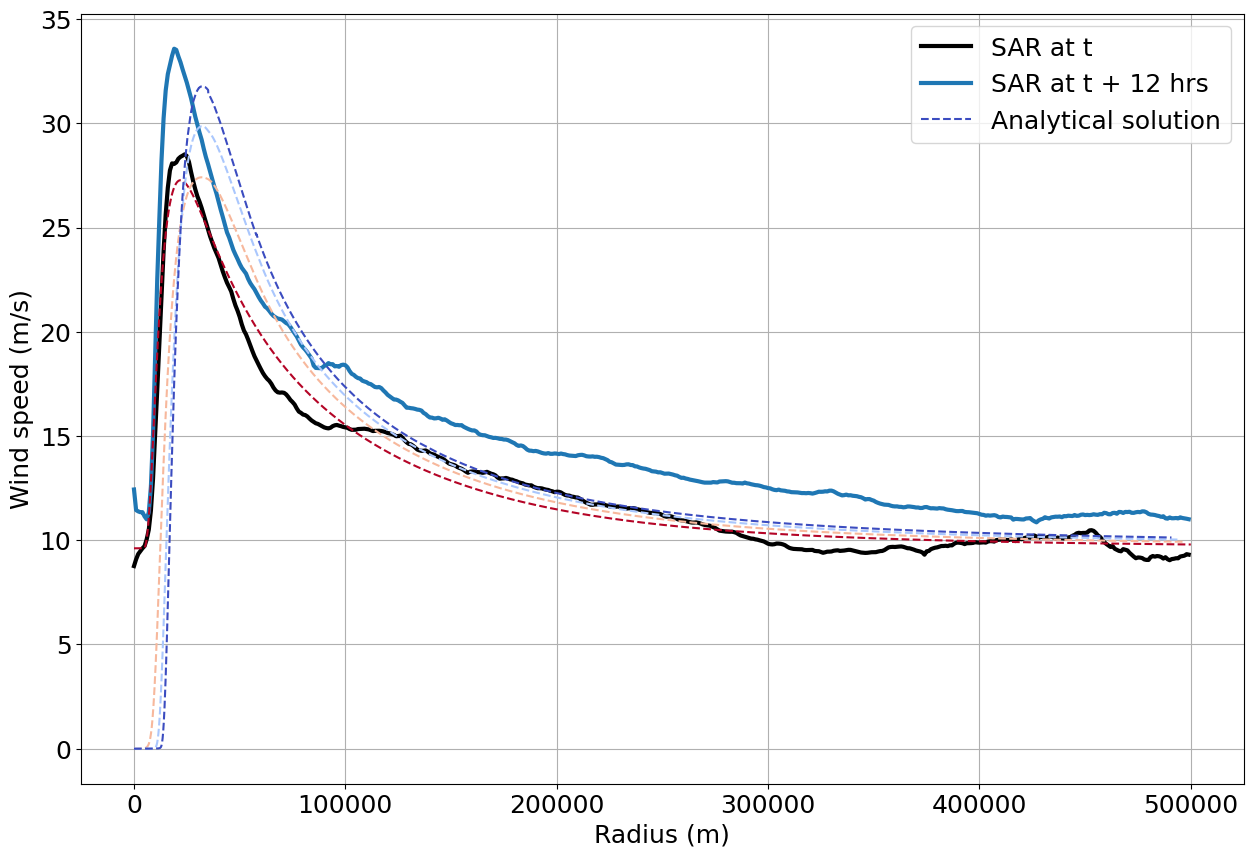

In [369]:
# Hyperparameters
HPRMS = {
    'dt':      1/2,     # non-dimensional time step
    'n_steps': n_steps, # hr, nb of iterations
    'K':       15,      # m^2/s, diffusivity coefficient
    'Cd_plus': 2.5e-3,  # [], drag coefficient, maximal at R+ (so shouldn't be tuned)
}

# Plot
print('TODO: Understand the noise generation for late iterations: maybe use Rmax instead of R+ for L? To avoid creating discontinuities.')
print('TODO: refine R+ computation.')
print('TODO: Re-compute (on paper) the expression of the constant Cd r v^2. Here I express it as a function of K, but I would like to express it as a function of Cd.')
print('Indeed I feel like Cd and K play the same role in this model.')
print('TODO: Rmax increases. Because the friction I used tends too quickly toward infinite. In fact, the friction probably saturates, so that Vmin_SAR is fitted. Take inital Vmin for instance.')
plt.plot(DS[str(i)].rad, DS[str(i)].wind_speed, c='k', linewidth=3, label='SAR at t')
# plt.plot(rs, VHS[str(i)], c='k', alpha=0.2, label='Holland fit to SAR at t')
plt.plot(DS[str(i + 1)].rad, DS[str(i + 1)].wind_speed, c='tab:blue', linewidth=3, label='SAR at t + 12 hrs')

# Run model
V = MODEL(rs, VHS[str(i)], fcors, HPRMS)

plt.xlabel('Radius (m)');plt.ylabel('Wind speed (m/s)')
plt.grid();plt.legend()

In [11]:
# # Plot
# plt.plot(DS['1'].rad, DS['1'].wind_speed, c='k', linewidth=3, label='SAR at t')
# plt.plot(rs, VHS['1'], c='k', alpha=0.2, label='Holland fit to SAR at t')
# plt.plot(DS['2'].rad, DS['2'].wind_speed, c='tab:blue', linewidth=3, label='SAR at t + 12 hrs')

# # Run model
# MODEL(rs, VHS['1'], float(abs(coriolis(DS['1'].lat_center))), HPRMS)

# plt.grid();plt.legend()